In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')

In [2]:
proteome = 'Human'
models = ['independent', 'ncov', 'nskew', 'nskewfcov', 'train']
k = 9

coincidence_probs = {}

for model in models:
    if not model == 'train':
        energy = make_energy(np.load('../maxent/data/{proteome}_{model}_k{k}_params.npz'.format(
            proteome=proteome, model=model, k=k)))
        F = np.float(pd.read_csv('../maxent/data/{proteome}_{model}_k{k}_entropy.csv'.format(
            proteome=proteome, model=model, k=k),
                                header=None, index_col=0).loc['F'])
        loglikelihood  = lambda seq: -energy(seq) + F
    matrix = load_matrix('data/{proteome}_{model}_k{k}_matrix.csv.gz'.format(
                         proteome=proteome, model=model, k=k))
    coincidence_empirical = calc_coincidence_prob(matrix)
    if not model == 'train':
        logp = np.array([loglikelihood(row) for row in matrix])
        coincidence_prob = np.mean(np.exp(logp))
        print(model, coincidence_prob, coincidence_empirical)
    else:
        coincidence_prob = coincidence_empirical
        print(model, coincidence_empirical)
    coincidence_probs[model] = coincidence_prob

independent 9.75602774408501e-12 9.087071185878195e-12
ncov 3.212161349322618e-11 3.46708012354559e-11
nskew 1.022484329489171e-09 1.000630080011192e-09
nskewfcov 1.5453543410085387e-09 1.4006724095888415e-09
train 1.204777877933248e-08


In [3]:
coincidence_probs = pd.Series(coincidence_probs, name='coincidence_prob')

In [5]:
# effective diversities
'%e'%np.exp(-np.mean(logp)),'%e'%(1/np.mean(np.exp(logp)))

('1.627788e+11', '6.471008e+08')

# test reproducibility on independent site model

In [6]:
model = 'independent'
f = np.load('../maxent/data/{proteome}_{model}_k{k}_params.npz'.format(
        proteome=proteome, model=model, k=k))['f']
np.sum(f**2)**9

9.747161813663533e-12

In [7]:
model_matrix = np.random.choice(np.arange(0, 20, 1), size=matrix.shape, p=f)
coincidence_empirical = calc_coincidence_prob(model_matrix)
coincidence_empirical

8.737568447959803e-12

# Plot

In [8]:
coincidence_probs['uniform'] = 1/20**k
coincidence_probs.sort_values(inplace=True)
labels = {'uniform' : 'uniform',
          'independent' : '1st moment',
          'ncov' : '2nd moment',
          'nskew' : '3rd moment',
          'nskewfcov' : '2-point',
          'train' : 'data'
         }
coincidence_probs.index = coincidence_probs.index.map(labels)

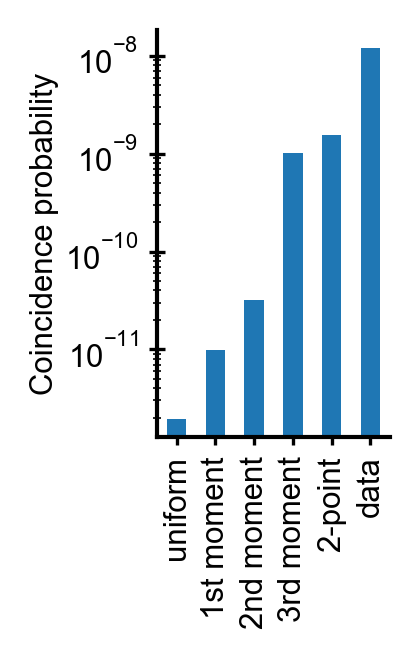

In [9]:
fig, ax = plt.subplots(figsize=(1.0, 1.8))
coincidence_probs.plot(kind='bar', log=True, ax=ax)
ax.set_ylabel('Coincidence probability')
fig.savefig('coincidence_prob.png')

# Empirical coincidences in data

In [10]:
proteomes = ['Human', 'Humannozf']
models = ['train', 'test']
k = 9
for proteome in proteomes:
    for model in models:
        matrix = load_matrix('data/{proteome}_{model}_k{k}_matrix.csv.gz'.format(
                                 proteome=proteome, model=model, k=k))
        coincidence_empirical = calc_coincidence_prob(matrix)
        print(proteome, model, coincidence_empirical)

Human train 1.204777877933248e-08
Human test 1.1292272071283768e-08
Humannozf train 6.044826871022473e-08
Humannozf test 5.913605194969167e-08


In [11]:
proteome = 'Human'
matrices = {}
for model in models:
    matrix = load_matrix('data/{proteome}_{model}_k{k}_matrix.csv.gz'.format(
                          proteome=proteome, model=model, k=k))
    matrices[model] = matrix_to_kmers(matrix)

In [12]:
intersection = set(matrices['test']).intersection(set(matrices['train']))

In [13]:
overlap = [kmer for kmer in matrices['test'] if kmer in intersection]

In [14]:
len(overlap)/(len(matrices['train'])*len(matrices['test']))

9.949567414319546e-09